<a href="https://colab.research.google.com/github/hongchen-wang/ML-QuantitativeTrading/blob/main/QuantitativeTrading_GARCH_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intraday Strategy Using GARCH Model

- Using simulated daily data and intraday 5-min data.
- Load Daily and 5-minute data.
- Define function to fit GARCH model on the daily data and predict 1-day ahead - volatility in a rolling window.
- Calculate prediction premium and form a daily signal from it.
- Merge with intraday data and calculate intraday indicators to form the intraday signal.
- Generate the position entry and hold until the end of the day.
- Calculate final strategy returns.

1. Load Simulated Daily and Simulated 5-minute data.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
!pip3 install arch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 8.9 MB/s eta 0:00:00


In [27]:
from google.colab import files
uploaded = files.upload()

Saving simulated_daily_data.csv to simulated_daily_data (1).csv


In [36]:
import io
daily_df = pd.read_csv(io.BytesIO(uploaded['simulated_daily_data (1).csv']))
daily_df['Date'] = pd.to_datetime(daily_df['Date'])
daily_df = daily_df.set_index('Date')
daily_df['log_return'] = np.log(daily_df['Adj Close']).diff()
daily_df

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log_return
Date,,,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN,NaN
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,NaN,-0.074643
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,NaN,-0.072402
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,NaN,0.035111
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,NaN,-0.024968
...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,NaN,0.011801
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,NaN,0.002597
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,NaN,-0.001520


In [9]:
uploaded = files.upload()

Saving simulated_5min_data.csv to simulated_5min_data.csv


,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log_return
Date,,,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN,NaN
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,NaN,-0.074643
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,NaN,-0.072402
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,NaN,0.035111
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,NaN,-0.024968
...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,NaN,0.011801
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,NaN,0.002597
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,NaN,-0.001520


In [11]:
intraday_5min_df = pd.read_csv(io.BytesIO(uploaded['simulated_5min_data.csv']))
intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])
intraday_5min_df = intraday_5min_df.set_index('datetime')
intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)
intraday_5min_df

,open,low,high,close,volume,Unnamed: 6,date
datetime,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,2021-09-29
...,...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,NaN,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,NaN,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,NaN,2023-09-20


2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.
-first calculating the 6-month rolling variance
-then creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

<Axes: xlabel='Date'>

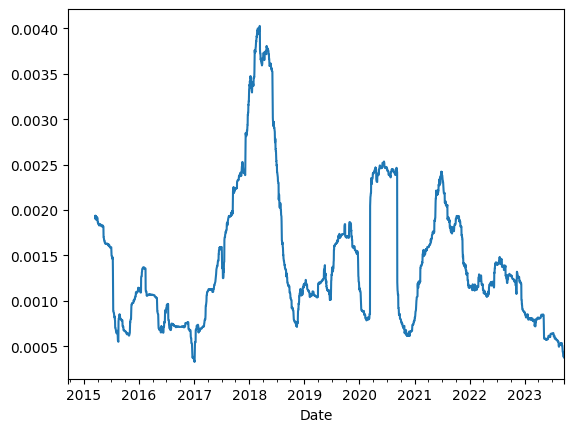

In [37]:
#variance of daily dataframe
daily_df['variance'] = daily_df['log_return'].rolling(180).var()
daily_df['variance'].plot()


In [ ]:
#optimized auto-regressive order of 1 and moving average order of 3
#p=1, q=3
from arch import arch_model

daily_df = daily_df['2020-01-01':]
def predict_volatility(x):
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5, disp='off')
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    # print(x.index[-1])
    return variance_forecast

daily_df['predictions'] = daily_df['log_return'].rolling(180).apply(lambda x: predict_volatility(x))
daily_df = daily_df.dropna()


<Axes: xlabel='Date'>

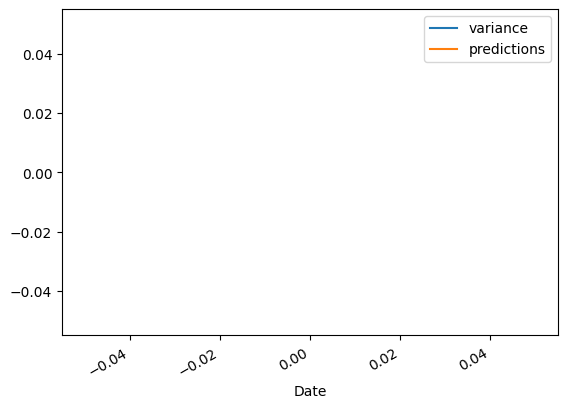

In [39]:
daily_df[['variance','predictions']].plot()

3. Calculate prediction premium and form a daily signal from it.
- calculating the prediction premium. And calculate its 6-month rolling standard deviation.

- From this we are creating our daily signal.

In [40]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium'] > x['premium_std'])
                                         else (-1 if (x['prediction_premium'] < x['premium_std']*-1)
                                         else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log_return,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,,


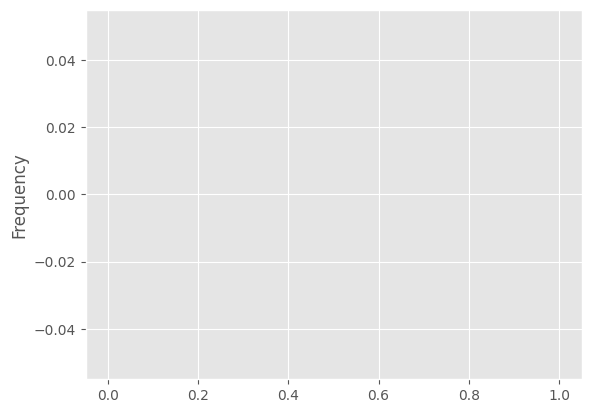

In [41]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

In [ ]:
!pip install pandas_ta


In [45]:
import pandas_ta
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

AttributeError: 'NoneType' object has no attribute 'iloc'

5. Generate the position entry and hold until the end of the day.

In [ ]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1)
                                        else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

6. Calculate final strategy returns.

In [ ]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()